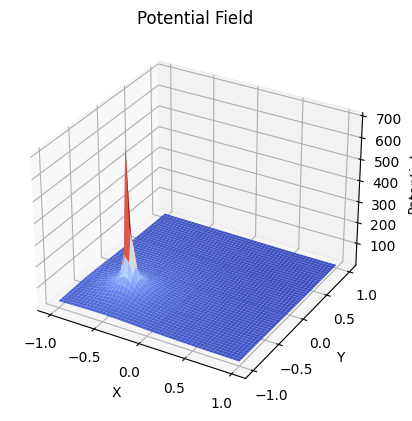

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
N = 50

# Create a meshgrid
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

# Define the goal position
goal = np.array([0.5, 0.5])

# Define the obstacle position
obstacle = np.array([-0.5, -0.5])

# Define the strength of the goal and obstacle potentials
k_goal = 5
k_obstacle = 10

# Calculate the potential field
U_goal = k_goal * np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
U_obstacle = k_obstacle / np.sqrt((X - obstacle[0])**2 + (Y - obstacle[1])**2)
U = U_goal + U_obstacle

# Plot the potential field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('Potential Field')
plt.show()


In [3]:
import sys
sys.path.append('../')
import lidar_tool

path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_1852/vehicle.tesla.model3.master/velodyne_semantic/0000001577.bin'
lidar_tool.vis_pt(path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[per label] 13
[label_str] -1.749570369720459 -19.64297103881836 -2.2200863361358643 5.979609489440918 5.155853271484375 2.3341016843914986 0.0 Truck 0.0
[label_str] -50.29932975769043 -24.164518356323242 -2.2661213874816895 1.8974494934082031 5.040367126464844 1.7341997027397156 0.0 Car 257.0
[label_str] 35.212684631347656 -6.986948251724243 -2.357139825820923 6.106971740722656 2.295947551727295 2.0167301297187805 0.0 Car 144.0
[label_str] -46.93398857116699 -7.54019021987915 -2.27884578704834 1.8503837585449219 4.39565372467041 1.475766897201538 0.0 Car 224.0
[label_str] -49.970502853393555 -3.779892385005951 -2.3411388397216797 0.5771369934082031 3.8643161058425903 1.1148613691329956 0.0 Car 238.0
[label_str] 12.242154755613747 40.62789400309191 -1.6831334829330444 1.0351296152733866 3.2393530530672106 0.656427621841

In [4]:
import open3d as o3d
import numpy as np

# Load point cloud sample data

pre_point = np.fromfile(path, dtype=np.dtype([
                                       ('x', np.float32),
                                       ('y', np.float32),
                                       ('z', np.float32),
                                       ('CosAngle', np.float32),
                                        ('ObjIdx', np.uint32),
                                       ('ObjTag', np.uint32)
                                   ]) ,count=-1)
semantic_point = np.array([list(elem) for elem in pre_point])

pcd  = o3d.geometry.PointCloud()

# keep point -10<x<10, -10<y<10, 0<z<10

semantic_point = semantic_point[(semantic_point[:,0]>-10) & (semantic_point[:,0]<10) & (semantic_point[:,1]>-10) & (semantic_point[:,1]<10) & (semantic_point[:,2]>0) & (semantic_point[:,2]<10)]


pcd.points = o3d.utility.Vector3dVector(semantic_point[:,:3])

# Compute normal vectors for each point
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Estimate normal vectors for each face
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Extract the point coordinates and normals
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)

# Concatenate the point coordinates and normals
data = np.concatenate((points, normals), axis=1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

# Get the cluster labels
labels = kmeans.labels_

# Print the number of points in each cluster
for i in range(n_clusters):
    print('Cluster {}: {} points'.format(i, np.sum(labels == i)))
    # Alpha形状算法提取点云表面
    # Compute the Alpha shape
alpha = 0.2
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)

print('Number of triangles: {}'.format(len(mesh.triangles)))

o3d.visualization.draw_geometries([mesh])




/home/ghosnp/miniconda3/envs/carla38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: 689 points
Cluster 1: 265 points
Cluster 2: 663 points
Number of triangles: 856


In [5]:
import numpy as np
from pathlib import Path

def load_pre_label(gt_json_path):
    if Path(gt_json_path).exists():
        pred_box = []
        with open(gt_json_path, 'r') as fobj:

            for line in fobj:
                l = line.strip().split(" ")
                try:
                    cx, cy, cz, sx, sy, sz, yaw, tag, mesh_cnt, time = l[0], l[1],l[2], l[3],l[4], l[5],l[6], l[7], l[8], l[9], l[10]
                    box_data = list(map(float,[ cx, cy, cz, sx, sy, sz, yaw, mesh_cnt]))
                    pred_box.append(box_data)
                    print("[label_str]",line)
                except:
                    print("[entropy infos]",line)
                
        return pred_box

In [6]:
txt_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_2155/vehicle.tesla.model3.master/velodyne_semantic/0000003232.txt'
import pandas as pd
df = pd.read_csv(txt_path, sep=" ", header=None)
df.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "time"]
df.head()

# 去除最后一行
df = df[:-1]


In [7]:
import time
import numpy as np
k = 100
lambda_ = df['mesh_cnt'].values
x = df['cx'].values
y = df['cy'].values

tick = time.time()


lambda_[lambda_ == 0] = 1

z = k / (x**2 + y**2) * np.log(lambda_)
tan = np.arctan2(y, x)

z2 = z * np.exp(1j * tan)  # 使用复数表示z和tan的乘积

sum_z = np.sum(z2)
tan_z = np.angle(sum_z)  # 计算复数的幅角
res_z = np.sum(z)
print(time.time() - tick)
print(np.abs(sum_z), tan_z)  # 使用np.abs计算复数的模
print(res_z)


0.0012488365173339844
0.18408974322055047 -1.039864208702555
3.73323264236941


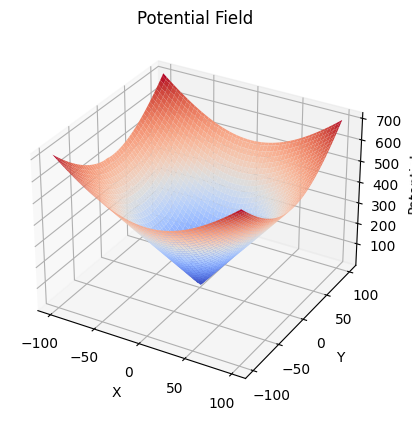

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
N = 100

# Create a meshgrid
x = np.linspace(-100, 100, N)
y = np.linspace(-100, 100, N)
X, Y = np.meshgrid(x, y)

# Define the goal position
goal = np.array([0.5, 0.5])

# Read obstacle positions from DataFrame
obstacles = df[['cx', 'cy']].values

# Define the strength of the goal and obstacle potentials
k_goal = 5
k_obstacle = 10

# Calculate the potential field
U_goal = k_goal * np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
U_obstacle = np.zeros_like(U_goal)

for obstacle in obstacles:
    U_obstacle += k_obstacle / np.sqrt((X - obstacle[0])**2 + (Y - obstacle[1])**2)

U = U_goal + U_obstacle

# Plot the potential field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('Potential Field')

plt.show()

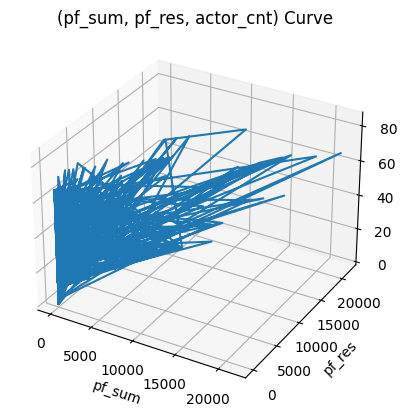

In [9]:
path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1018_2027/vehicle.tesla.model3.master/velodyne_semantic'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data(source_dir):
    # only read the last line of the file
    with open(source_dir, "r") as file:
        data = file.readlines()[-1]
    return data


df = pd.DataFrame(columns=['actor_cnt', 'scan_entropy', 'bev_entropy', 'current_entropy_score', 'filtered_actors', 'selected_walkers', 'pf_sum', 'pf_tan', 'pf_res'])
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        data = read_data(os.path.join(path, filename)).split(" ")
        df.loc[len(df)] = data


# change pf_sum, pf_res, actor_cnt type into float
df['pf_sum'] = df['pf_sum'].astype(float)
df['pf_res'] = df['pf_res'].astype(float)
df['actor_cnt'] = df['actor_cnt'].astype(float)


# draw the curve of (pf_sum,pf_res,actor_cnt) in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(df['pf_sum'], df['pf_res'], df['actor_cnt'])
ax.set_xlabel('pf_sum')
ax.set_ylabel('pf_res')
ax.set_zlabel('actor_cnt')
ax.set_title('(pf_sum, pf_res, actor_cnt) Curve')
plt.show()


# visualize the pf_sum, draw the curve, only keep pf_sum < 1000
# x start at 438705, add 3 to each frame
# show text actor_cnt on the curve

# plt.figure(figsize=(10, 40))
# df = df.astype(float)
# df = df[df['pf_sum'] < 1000]
# df['pf_sum'] = df['pf_sum'].astype(int)
# df['frame'] = df.index * 3 + 438705
# df.plot(x='frame', y='pf_sum')
# for i in range(len(df)):
#     plt.text(df['frame'].iloc[i], df['pf_sum'].iloc[i], df['actor_cnt'].iloc[i])
# plt.xlabel('frame')
# plt.ylabel('pf_sum')
# plt.show()


In [10]:
import pandas as pd
import numpy as np
import os

path_1 = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1019_1520/vehicle.tesla.model3.master/velodyne_semantic'
path_2 = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1019_1922/vehicle.tesla.model3.master/velodyne_semantic'

df = pd.DataFrame(columns=['cx', 'cy', 'cz', 'sx', 'sy', 'sz', 'yaw', 'tag', 'mesh_cnt', 'dist'])

for filename in os.listdir(path_1):
    if filename.endswith(".txt"):
        data = pd.read_csv(os.path.join(path_1, filename), sep=" ", header=None)
        data.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "dist"]
        data = data[:-1]
        row = pd.DataFrame(data.iloc[0]).T
        df = pd.concat([df, row], ignore_index=True)

for filename in os.listdir(path_2):
    if filename.endswith(".txt"):
        data = pd.read_csv(os.path.join(path_2, filename), sep=" ", header=None)
        data.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "dist"]
        data = data[:-1]
        row = pd.DataFrame(data.iloc[0]).T
        df = pd.concat([df, row], ignore_index=True)

# spilt the df by 'tag', totally 3 sub df, tag='Car', 'Bus', 'Truck'
car_df = df[df['tag'] == 'Car']
bus_df = df[df['tag'] == 'Bus']
truck_df = df[df['tag'] == 'Truck']

# change the type of 'cx', 'cy', 'cz', 'sx', 'sy', 'sz', 'yaw', 'mesh_cnt' into float
car_df['cx'] = car_df['cx'].astype(float)
car_df['cy'] = car_df['cy'].astype(float)
car_df['cz'] = car_df['cz'].astype(float)
car_df['sx'] = car_df['sx'].astype(float)
car_df['sy'] = car_df['sy'].astype(float)
car_df['sz'] = car_df['sz'].astype(float)
car_df['yaw'] = car_df['yaw'].astype(float)
car_df['mesh_cnt'] = car_df['mesh_cnt'].astype(float)
car_df['dist'] = car_df['dist'].astype(float)

bus_df['cx'] = bus_df['cx'].astype(float)
bus_df['cy'] = bus_df['cy'].astype(float)
bus_df['cz'] = bus_df['cz'].astype(float)
bus_df['sx'] = bus_df['sx'].astype(float)
bus_df['sy'] = bus_df['sy'].astype(float)
bus_df['sz'] = bus_df['sz'].astype(float)
bus_df['yaw'] = bus_df['yaw'].astype(float)
bus_df['mesh_cnt'] = bus_df['mesh_cnt'].astype(float)
bus_df['dist'] = bus_df['dist'].astype(float)

truck_df['cx'] = truck_df['cx'].astype(float)
truck_df['cy'] = truck_df['cy'].astype(float)
truck_df['cz'] = truck_df['cz'].astype(float)
truck_df['sx'] = truck_df['sx'].astype(float)
truck_df['sy'] = truck_df['sy'].astype(float)
truck_df['sz'] = truck_df['sz'].astype(float)
truck_df['yaw'] = truck_df['yaw'].astype(float)
truck_df['mesh_cnt'] = truck_df['mesh_cnt'].astype(float)
truck_df['dist'] = truck_df['dist'].astype(float)


/tmp/ipykernel_317201/2187703547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['cx'] = car_df['cx'].astype(float)
/tmp/ipykernel_317201/2187703547.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['cy'] = car_df['cy'].astype(float)
/tmp/ipykernel_317201/2187703547.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

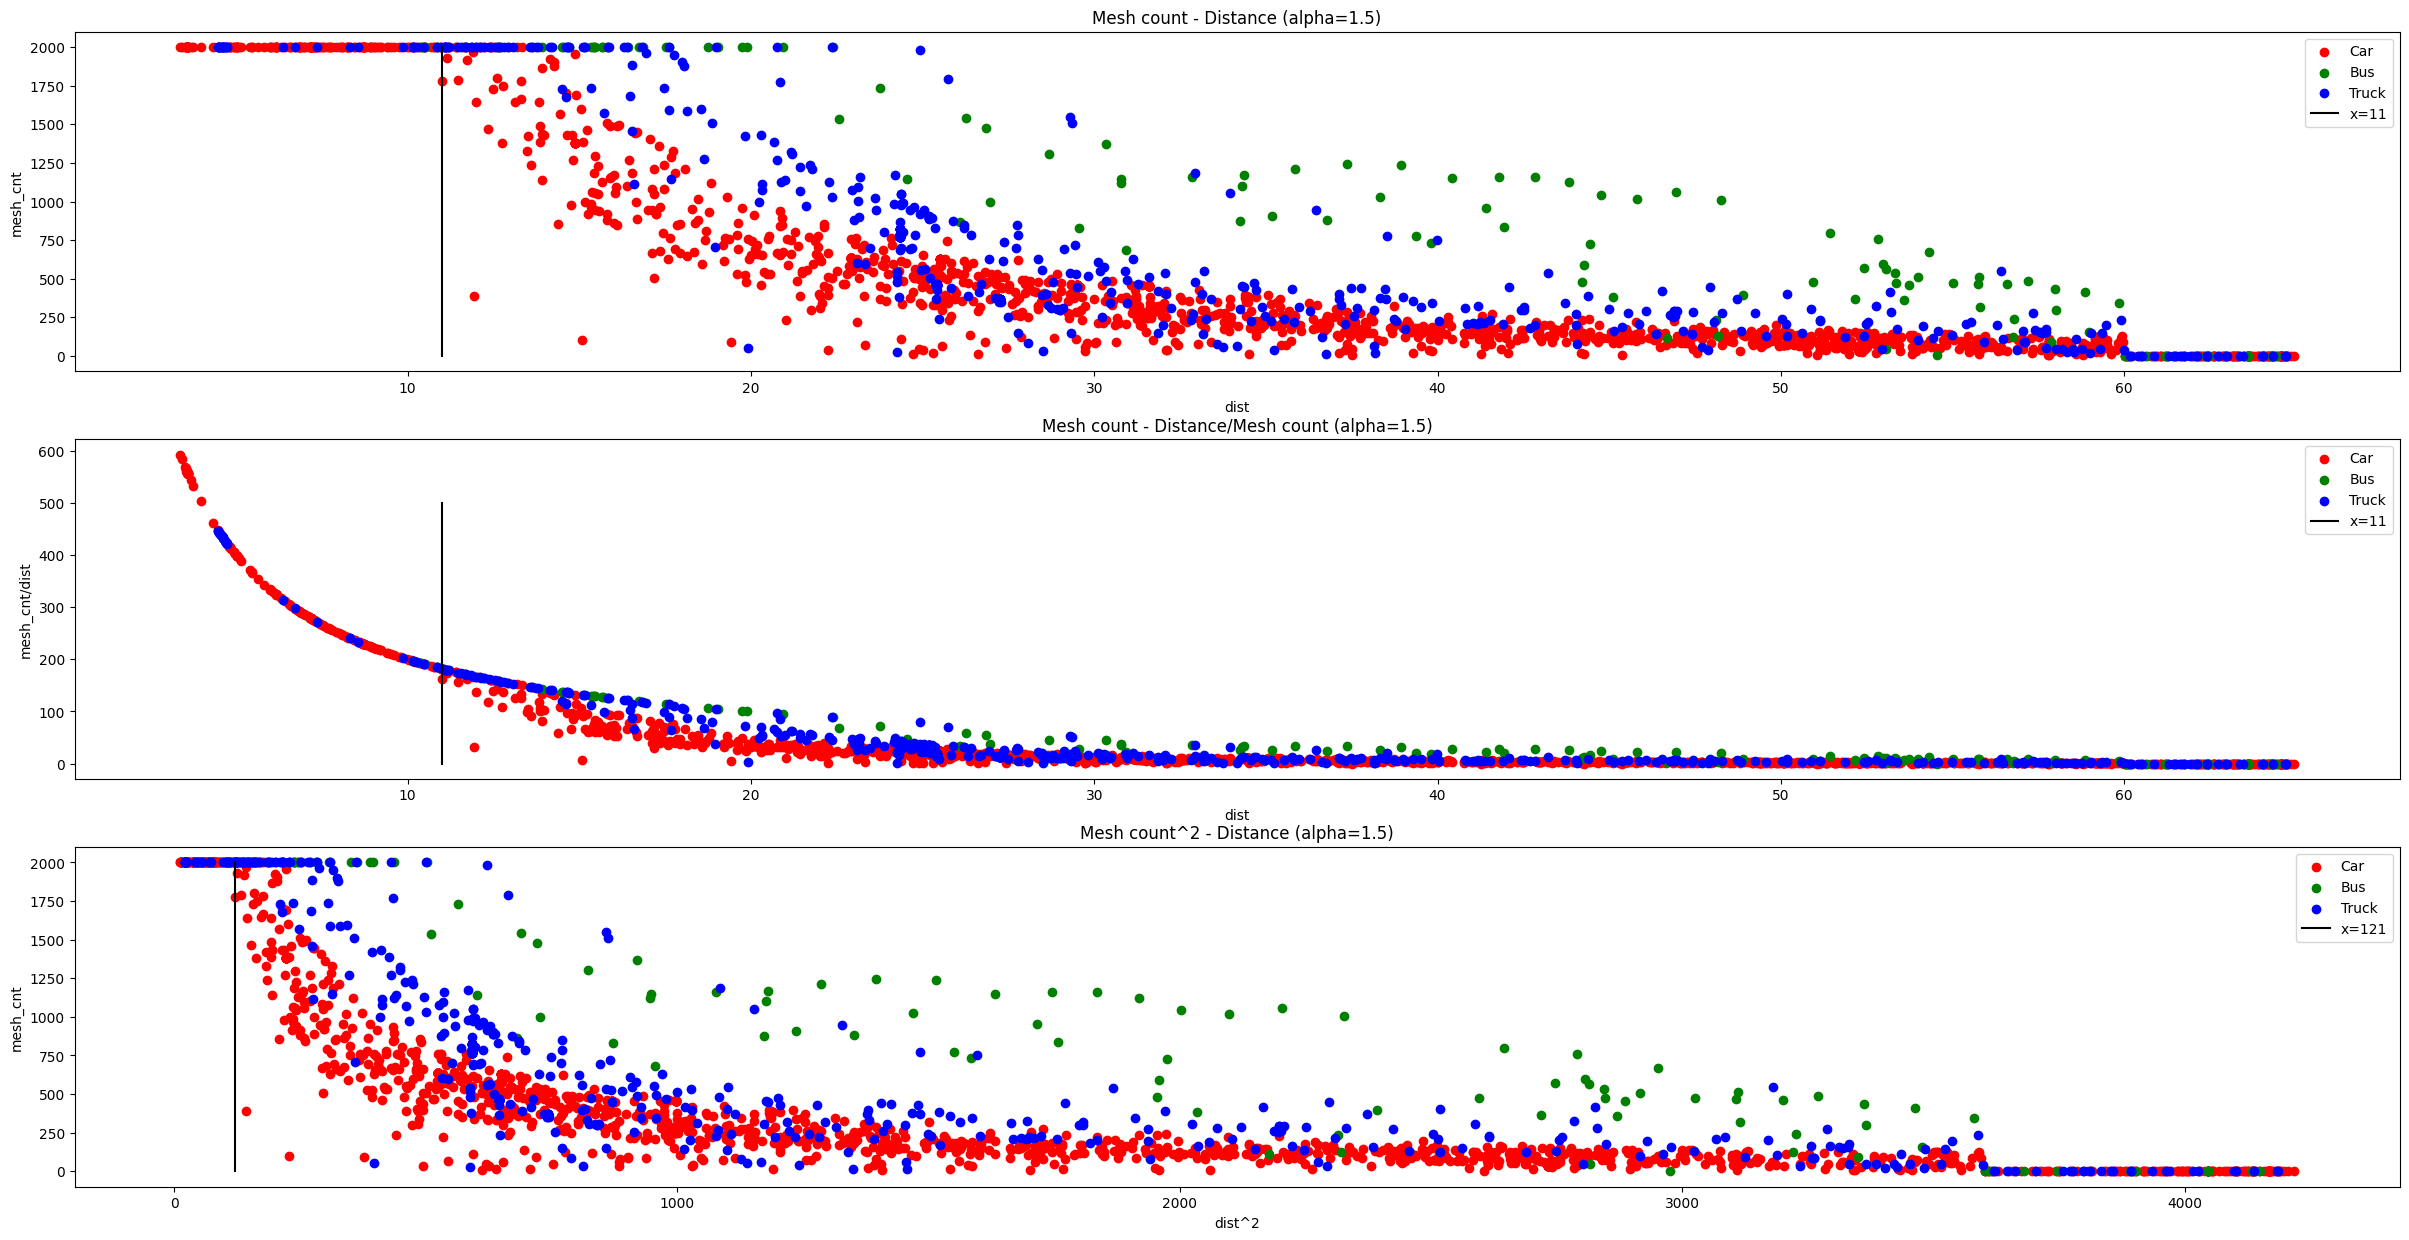

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(30, 15))

# Filter the dataframes to only keep points where x < 4000
car_df_filtered = car_df[car_df['dist'] < 65]
bus_df_filtered = bus_df[bus_df['dist'] < 65]
truck_df_filtered = truck_df[truck_df['dist'] < 65]

ax1.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt'], c='r', label='Car')
ax1.scatter(bus_df_filtered['dist'], bus_df_filtered['mesh_cnt'], c='g', label='Bus')
ax1.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax1.plot([11, 11], [0, 2000], c='black', label='x=11')
ax1.legend()
ax1.set_title('Mesh count - Distance (alpha=1.5)')
ax1.set_xlabel('dist')
ax1.set_ylabel('mesh_cnt')

ax2.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']/car_df_filtered['dist'], c='r', label='Car')
ax2.scatter(bus_df_filtered['dist'], bus_df_filtered['mesh_cnt']/bus_df_filtered['dist'], c='g', label='Bus')
ax2.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']/truck_df_filtered['dist'], c='b', label='Truck')
ax2.plot([11, 11], [0, 500], c='black', label='x=11')
ax2.legend()
ax2.set_title('Mesh count - Distance/Mesh count (alpha=1.5)')
ax2.set_xlabel('dist')
ax2.set_ylabel('mesh_cnt/dist')

ax3.scatter(car_df_filtered['dist']**2, car_df_filtered['mesh_cnt'], c='r', label='Car')
ax3.scatter(bus_df_filtered['dist']**2, bus_df_filtered['mesh_cnt'], c='g', label='Bus')
ax3.scatter(truck_df_filtered['dist']**2, truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax3.plot([121, 121], [0, 2000], c='black', label='x=121')
ax3.legend()
ax3.set_title('Mesh count^2 - Distance (alpha=1.5)')
ax3.set_xlabel('dist^2')
ax3.set_ylabel('mesh_cnt')

plt.show()


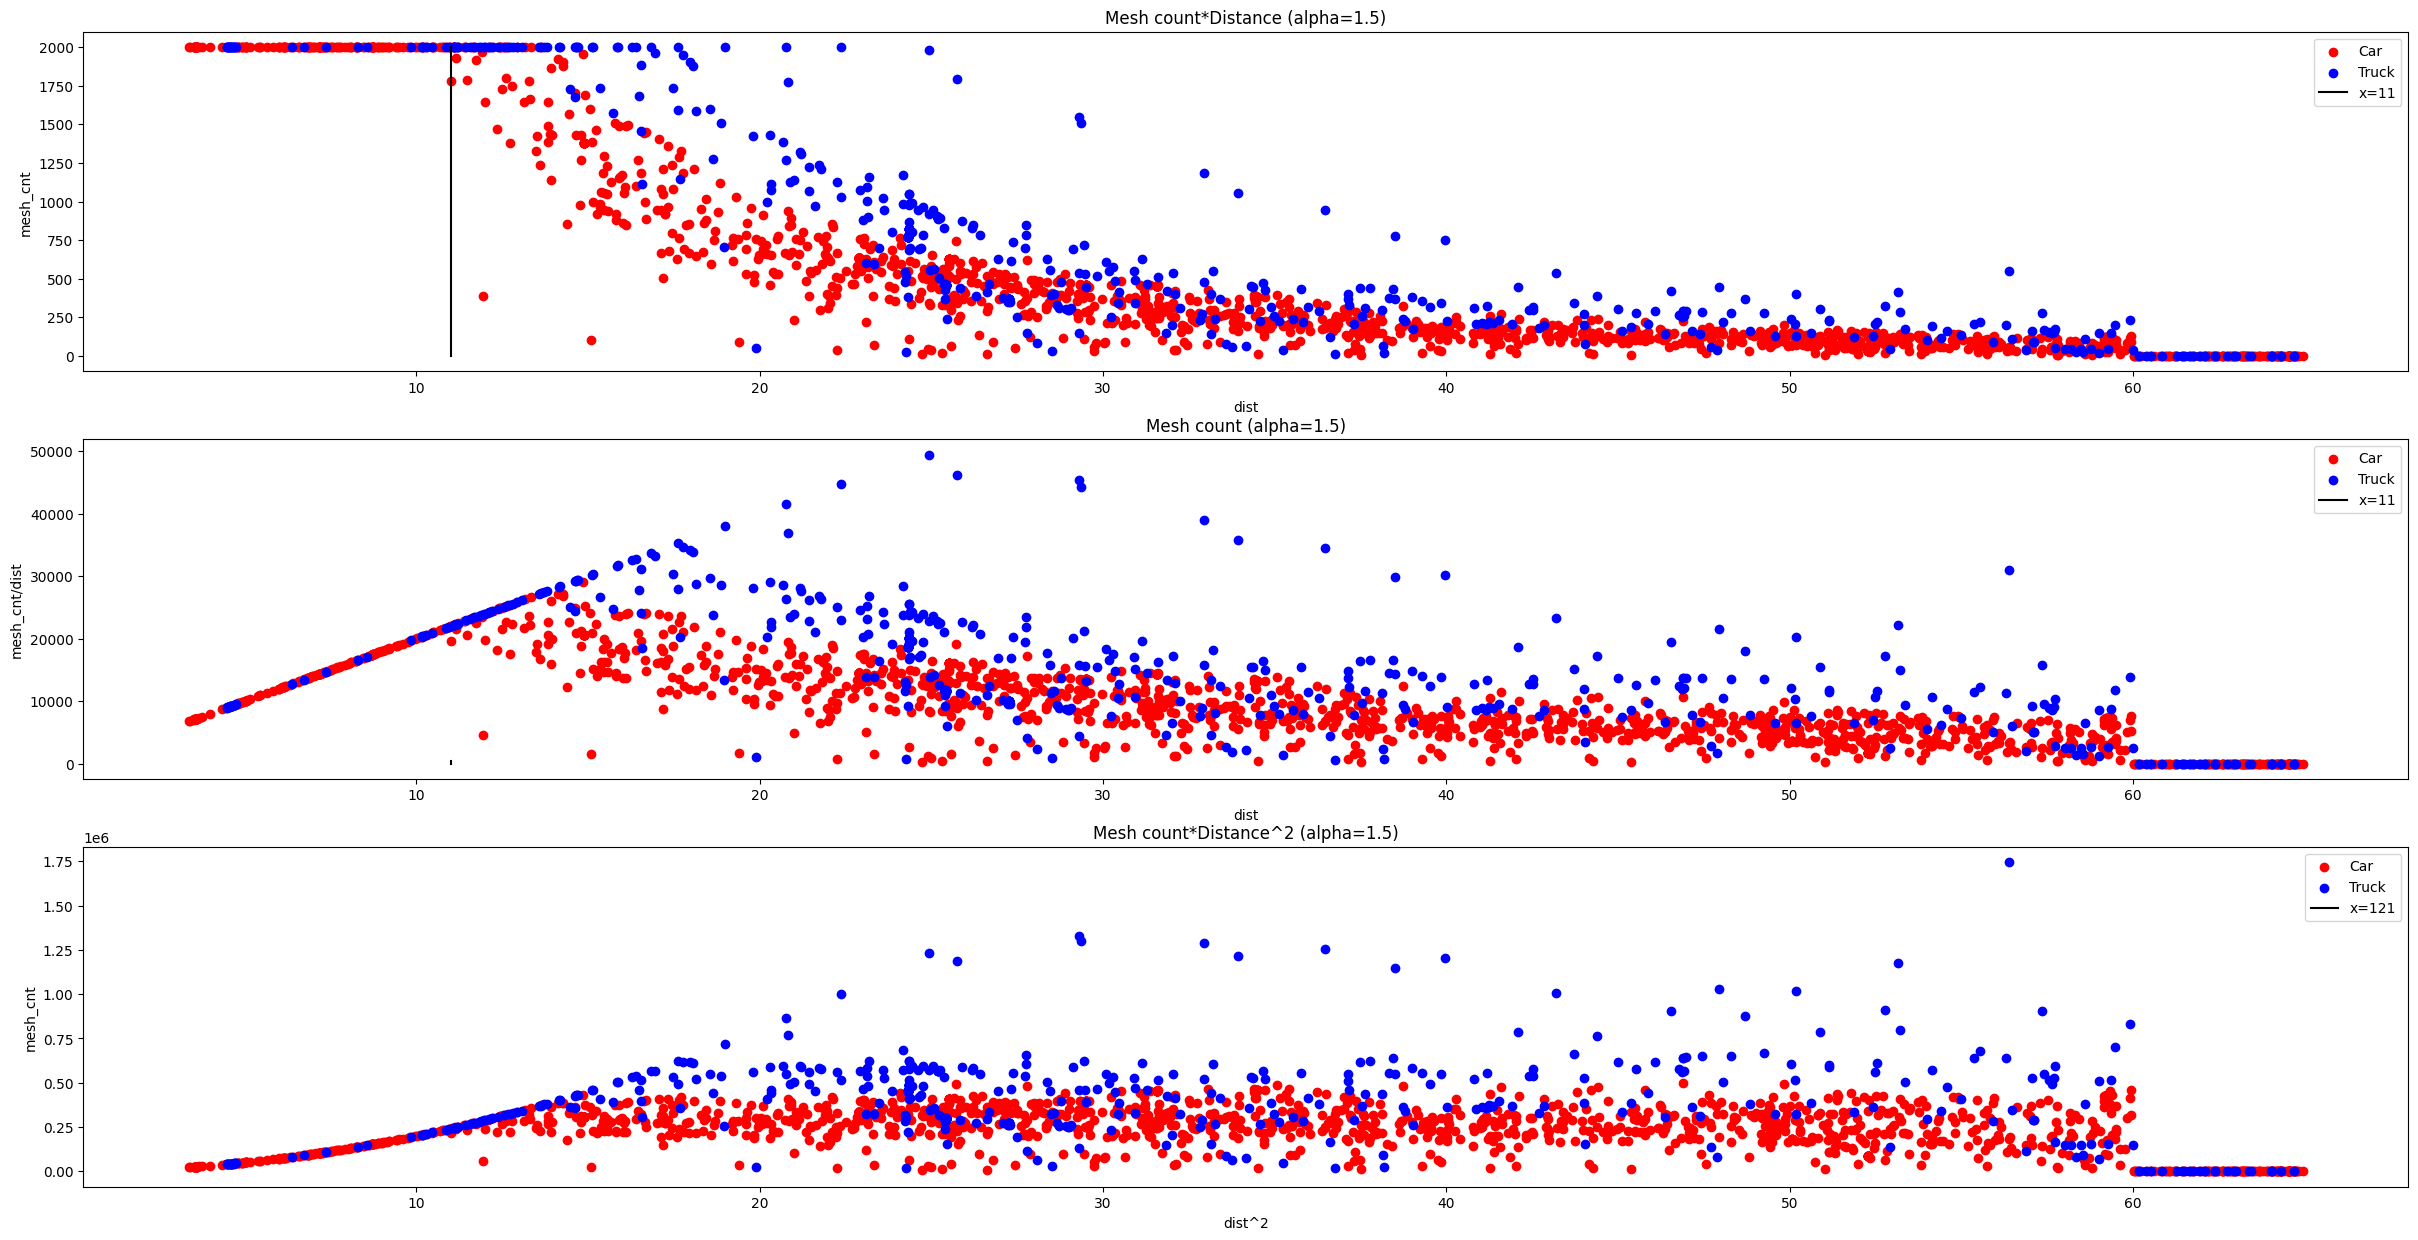

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(30, 15))

# Filter the dataframes to only keep points where x < 4000
car_df_filtered = car_df[car_df['dist'] < 65]
bus_df_filtered = bus_df[bus_df['dist'] < 65]
truck_df_filtered = truck_df[truck_df['dist'] < 65]

ax1.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt'], c='r', label='Car')
ax1.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt'], c='b', label='Truck')
ax1.plot([11, 11], [0, 2000], c='black', label='x=11')
ax1.legend()
ax1.set_title('Mesh count*Distance (alpha=1.5)')
ax1.set_xlabel('dist')
ax1.set_ylabel('mesh_cnt')

ax2.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']*car_df_filtered['dist'], c='r', label='Car')
ax2.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']*truck_df_filtered['dist'], c='b', label='Truck')
ax2.plot([11, 11], [0, 500], c='black', label='x=11')
ax2.legend()
ax2.set_title('Mesh count (alpha=1.5)')
ax2.set_xlabel('dist')
ax2.set_ylabel('mesh_cnt/dist')

ax3.scatter(car_df_filtered['dist'], car_df_filtered['mesh_cnt']*car_df_filtered['dist']**2, c='r', label='Car')
ax3.scatter(truck_df_filtered['dist'], truck_df_filtered['mesh_cnt']*truck_df_filtered['dist']**2, c='b', label='Truck')
ax3.plot([11, 11], [0, 2000], c='black', label='x=121')
ax3.legend()
ax3.set_title('Mesh count*Distance^2 (alpha=1.5)')
ax3.set_xlabel('dist^2')
ax3.set_ylabel('mesh_cnt')

plt.show()

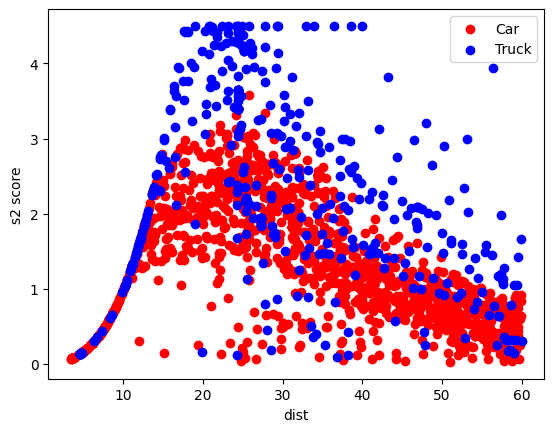

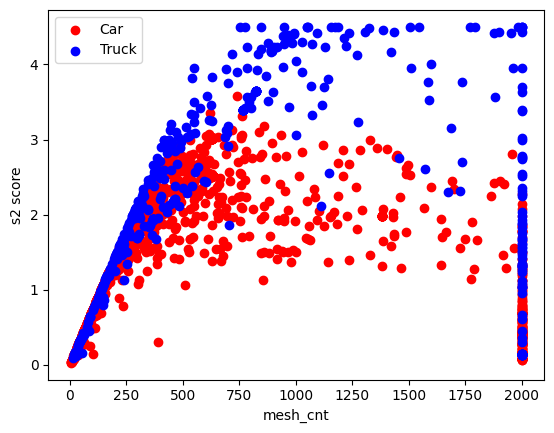

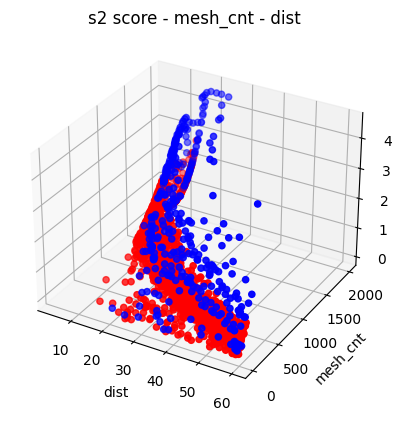

In [16]:
car_df_filtered = car_df[(car_df['dist'] > 0) & (car_df['dist'] <= 60)]
truck_df_filtered = truck_df[(truck_df['dist'] > 0) & (truck_df['dist'] <= 60)]

x = car_df_filtered['dist'] / 60
yc = (car_df_filtered['dist']**2 * (car_df_filtered['mesh_cnt'])) /(1e6*(x * np.log(x) + 0.5))
x = truck_df_filtered['dist'] / 60
yt = (truck_df_filtered['dist']**2 * (truck_df_filtered['mesh_cnt'])) /(1e6*(x * np.log(x) + 0.5))

yc[yc > 4.5] = 4.5
yt[yt > 4.5] = 4.5

# visualiz,(x,y)
plt.scatter(car_df_filtered['dist'], yc,c='r', label='Car')
plt.scatter(truck_df_filtered['dist'], yt,c='b', label='Truck')
plt.xlabel('dist')
plt.ylabel('s2 score')
plt.legend()
plt.show()

plt.scatter(car_df_filtered['mesh_cnt'], yc,c='r', label='Car')
plt.scatter(truck_df_filtered['mesh_cnt'], yt,c='b', label='Truck')
plt.xlabel('mesh_cnt')
plt.ylabel('s2 score')
plt.legend()
plt.show()


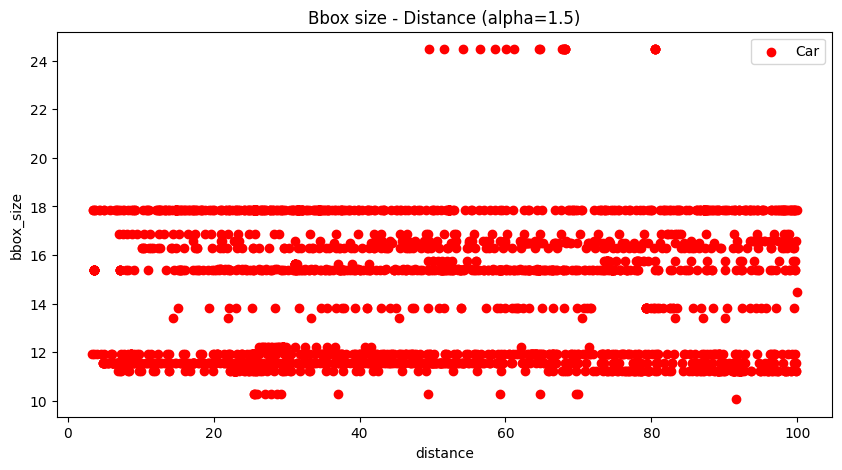

In [15]:
car_bbox_size = car_df['sx'] * car_df['sy'] * car_df['sz']
bus_bbox_size = bus_df['sx'] * bus_df['sy'] * bus_df['sz']
truck_bbox_size = truck_df['sx'] * truck_df['sy'] * truck_df['sz']

# visualize the bbox size of each tag
plt.figure(figsize=(10, 5))
plt.scatter(car_df['dist'], car_bbox_size, c='r', label='Car')
# plt.scatter(bus_df['dist'], bus_bbox_size, c='g', label='Bus')
# plt.scatter(truck_df['dist'], truck_bbox_size, c='b', label='Truck')
plt.legend()
plt.title('Bbox size - Distance (alpha=1.5)')
plt.xlabel('distance')
plt.ylabel('bbox_size')
plt.show()